# 3. Modeling
📒 `3.0-rc-modeling.ipynb`

**Objetivo:** Construir, treinar e otimizar modelos preditivos capazes de identificar falhas nas máquinas e estimar a probabilidade associada a cada classe de defeito.

⚙️ **Reflexão:**

- **Pergunta de negócio:** “Dado o vetor de sensores, o equipamento falhará?”
- **Custo típico:** um falso negativo (falhar e o modelo dizer “OK”) é pior que um falso positivo.
- **Métricas avaliadas:** :
    - Recall
    - Precision
    - F1 (f1)
    - Accuracy

In [ ]:
# === Imports ===
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from joblib import load

# Pipeline
from sklearn.pipeline import Pipeline
# Cross-Validation
from sklearn.model_selection import StratifiedKFold, cross_validate, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder

# Modelos
from sklearn.linear_model import LogisticRegression # Regressão Logística   
from sklearn.ensemble import RandomForestClassifier # Random Forest
#from sklearn.utils.class_weight import compute_sample_weight
from xgboost import XGBClassifier # XGBoost

# Métricas de Avaliação
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Carrega Funções Auxiliares
import sys
import os

# Carrega as funções auxiliares
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
from src._utils import obter_medidas


##  0. Carregar artefatos e dados de treino e teste

In [ ]:
# Carrega os dados tratados
X_train = pd.read_csv("../data/interim/X_train.csv")
X_test  = pd.read_csv("../data/interim/X_test.csv")
y_train_df = pd.read_csv("../data/interim/y_train.csv")
y_test_df  = pd.read_csv("../data/interim/y_test.csv")

# Carrega o artefato
spec_path   = "../models/artifacts/preprocessing_spec.joblib"
spec = load(spec_path)
# Carrega o preprocessor
preprocessor = spec.get("preprocessor")
RANDOM_SEED  = spec.get("random_seed", 42)
target_name  = spec.get("target_name", "falha_maquina")

# Se o artifact ainda aponta para 'tipo_falha', força para o binário e avisa:
if target_name != "falha_maquina":
    print(f"[AVISO] target_name no artifato especificado = '{target_name}'. "
          f"Ajustando para 'falha_maquina' para modelagem binária.")
    target_name = "falha_maquina"

# Seleciona a coluna alvo corretamente e normaliza para 0/1 (pd.Series)
y_train = (y_train_df[target_name] if target_name in y_train_df.columns else y_train_df.iloc[:, 0]).astype(int)
y_test  = (y_test_df[target_name]  if target_name in y_test_df.columns  else y_test_df.iloc[:, 0]).astype(int)

preprocessor


## 1. Modeling

- **Baseline:** LogisticRegression()
- **Ensemble:**  RandomForestClassifier(), XGBClassifier()

### i) Baseline - LogisticRegression() 

In [ ]:
# Cross-Validation (5 folds) para evitar overfitting
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)

# Pipeline baseline - Considerando o class_weight='balanced' para compensar os desbalanceamentos da classe positiva (falha=1)
lr_pipe_baseline = Pipeline(steps=[
    ("preprocessing", preprocessor),
    ("model", LogisticRegression(max_iter=1000, class_weight='balanced', random_state=RANDOM_SEED))
])

# Utilizando o cross_validate para incluir multiplos scores e reduzir o overfitting
scores = cross_validate(
    lr_pipe_baseline, 
    X_train, 
    y_train,
    cv=cv,
    scoring=['recall'],
    return_train_score=True
    )

# Fit
lr_pipe_baseline.fit(X_train, y_train)

# Predições
y_pred_lr_baseline = lr_pipe_baseline.predict(X_test)
y_proba_lr_baseline = lr_pipe_baseline.predict_proba(X_test)


### ii) LogisticRegression() com Otmização de Parâmetros

In [ ]:
# Aplicar o preprocessamento aos dados
X_train_transformed = preprocessor.fit_transform(X_train)

# Cross-Validation (5 folds) para evitar overfitting
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)

# Parâmetros para o Grid Search (l1 lasso l2 ridge) para evitar overfitting
param_grid = {
    'C': [0.01, 0.1, 1],
    'penalty': ['l2'],
    'solver': ['lbfgs']   # exige entrada densa
}

# Grid Search para encontrar os melhores hiperparâmetros
gs = GridSearchCV(
    estimator=LogisticRegression(max_iter=1000, class_weight='balanced', random_state=RANDOM_SEED), 
    param_grid=param_grid, 
    cv=cv, 
    scoring='recall', # metrica alvo
    n_jobs=1,  # Reduced parallelization to avoid serialization issues
    refit=True
) 

# Fit no Grid Search com os dados já transformados
gs.fit(X_train_transformed, y_train)


# Criar o pipeline final com os melhores parâmetros
lr_pipe_tuned = Pipeline(steps=[
    ("preprocessing", preprocessor),
    ("model", LogisticRegression(max_iter=1000, class_weight='balanced', random_state=RANDOM_SEED))
])

# Treinar o pipeline final
lr_pipe_tuned.fit(X_train, y_train)

# Fazer predições
y_pred_lr_tuned = lr_pipe_tuned.predict(X_test)
y_proba_lr_tuned = lr_pipe_tuned.predict_proba(X_test)


### iii) Random Forest com Otmizaão de Parâmetros

In [ ]:
# Aplicar o preprocessamento aos dados
X_train_transformed = preprocessor.fit_transform(X_train)

# Cross-Validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)

# Parâmetros para o Random Search
rf_param_grid = {
    "n_estimators": [100, 200, 300],
    "max_depth": [None, 8, 12, 16],
    "min_samples_leaf": [1, 2, 4],
    "max_features": ["sqrt", None],
}

# Random Search 
rf_search = RandomizedSearchCV(
    RandomForestClassifier(random_state=RANDOM_SEED, class_weight='balanced', n_jobs=-1),
    rf_param_grid,
    n_iter=12, 
    cv=cv,
    scoring="recall",  
    n_jobs=1,  # Reduzido para evitar problemas de serialização
    random_state=RANDOM_SEED,
    refit=True # refit para o melhor modelo
)

# Fit no Random Search com os dados já transformados
rf_search.fit(X_train_transformed, y_train)

# Criar o pipeline final com os melhores parâmetros
best_pipe = Pipeline(steps=[
    ("preprocessing", preprocessor),
    ("model", RandomForestClassifier(**rf_search.best_params_, 
                                   random_state=RANDOM_SEED, 
                                   class_weight='balanced', 
                                   n_jobs=-1))
])

# Treinar o pipeline final
best_pipe.fit(X_train, y_train)

# Fazer predições
y_pred_rf_tuned = best_pipe.predict(X_test)
y_proba_rf_tuned = best_pipe.predict_proba(X_test)

### iv) Ensemble Models: XGBoost com Otmização de Parâmetros

In [25]:
# Primeiro, vamos aplicar o preprocessamento aos dados
X_train_transformed = preprocessor.fit_transform(X_train)

# Cross-Validation
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=RANDOM_SEED)

# === Lidar com desbalanceamento para XGB ===
pos = (y_train == 1).sum()
neg = (y_train == 0).sum()
scale_pos_weight = neg / max(pos, 1)

# Parâmetros para o Random Search sem o prefixo 'model__'
xgb_dist = {
    "n_estimators": [200, 400, 600],
    "max_depth": [4, 6, 8],
    "learning_rate": [0.05, 0.1, 0.2],
    "subsample": [0.7, 1.0],
    "colsample_bytree": [0.7, 1.0],
}

# Random Search 
xgb_search = RandomizedSearchCV(
    XGBClassifier(
        objective="binary:logistic",
        eval_metric="logloss",
        tree_method="hist",
        random_state=RANDOM_SEED,
        n_jobs=-1,
        scale_pos_weight=scale_pos_weight
    ),
    xgb_dist,
    n_iter=12,
    cv=cv,
    scoring="recall",
    n_jobs=1,  # Reduzido para evitar problemas de serialização
    random_state=RANDOM_SEED,
    refit=True
)

# Fit no Random Search com os dados já transformados
xgb_search.fit(X_train_transformed, y_train)

# Criar o pipeline final com os melhores parâmetros
best_pipe = Pipeline(steps=[
    ("preprocessing", preprocessor),
    ("model", XGBClassifier(
        **xgb_search.best_params_,
        objective="binary:logistic",
        eval_metric="logloss",
        tree_method="hist",
        random_state=RANDOM_SEED,
        n_jobs=-1,
        scale_pos_weight=scale_pos_weight
    ))
])

# Treinar o pipeline final
best_pipe.fit(X_train, y_train)

# Fazer predições
y_pred_xgb_tuned = best_pipe.predict(X_test)
y_proba_xgb_tuned = best_pipe.predict_proba(X_test)[:,1]

## 2. Avaliação dos Modelos

#### Obtendo as medidas das métricas principais:
- **Primárias:**
    - Recall;
    - F1-Score;
    - Precision;

- **Secundária:**
    - Acuraccy;

In [27]:
# Baseline - LogisticRegression() 
# Obter as medidas das métricas principais:

print("LogisticRegression() Baseline")
print("--------------------------------")
print("Classification Report:")
print(classification_report(y_test, y_pred_lr_baseline, digits=4, zero_division=0))
print("--------------------------------")

print("LogisticRegression() Hyperparameters tuned")
print("--------------------------------")
print("Classification Report:")
print(classification_report(y_test, y_pred_lr_tuned, digits=4, zero_division=0))
print("--------------------------------")



LogisticRegression() Baseline
--------------------------------
Classification Report:
              precision    recall  f1-score   support

           0     0.9968    0.7697    0.8687      6539
           1     0.0546    0.8447    0.1026       103

    accuracy                         0.7709      6642
   macro avg     0.5257    0.8072    0.4856      6642
weighted avg     0.9822    0.7709    0.8568      6642

--------------------------------
LogisticRegression() Hyperparameters tuned
--------------------------------
Classification Report:
              precision    recall  f1-score   support

           0     0.9968    0.7697    0.8687      6539
           1     0.0546    0.8447    0.1026       103

    accuracy                         0.7709      6642
   macro avg     0.5257    0.8072    0.4856      6642
weighted avg     0.9822    0.7709    0.8568      6642

--------------------------------


In [28]:

print("RandomForestClassifier() Hyperparameters tuned")
print("--------------------------------")
print("Classification Report:")
print(classification_report(y_test, y_pred_rf_tuned, digits=4, zero_division=0))
print("--------------------------------")

print("XGBoost() Hyperparameters tuned")
print("--------------------------------")
print("Classification Report:")
print(classification_report(y_test, y_pred_xgb_tuned, digits=4, zero_division=0))
print("--------------------------------")

RandomForestClassifier() Hyperparameters tuned
--------------------------------
Classification Report:
              precision    recall  f1-score   support

           0     0.9938    0.9622    0.9778      6539
           1     0.2058    0.6214    0.3092       103

    accuracy                         0.9569      6642
   macro avg     0.5998    0.7918    0.6435      6642
weighted avg     0.9816    0.9569    0.9674      6642

--------------------------------
XGBoost() Hyperparameters tuned
--------------------------------
Classification Report:
              precision    recall  f1-score   support

           0     0.9955    0.9531    0.9738      6539
           1     0.1963    0.7282    0.3093       103

    accuracy                         0.9496      6642
   macro avg     0.5959    0.8406    0.6416      6642
weighted avg     0.9831    0.9496    0.9635      6642

--------------------------------


Matriz de Confusão
--------------------------------
LogisticRegression() Baseline
--------------------------------


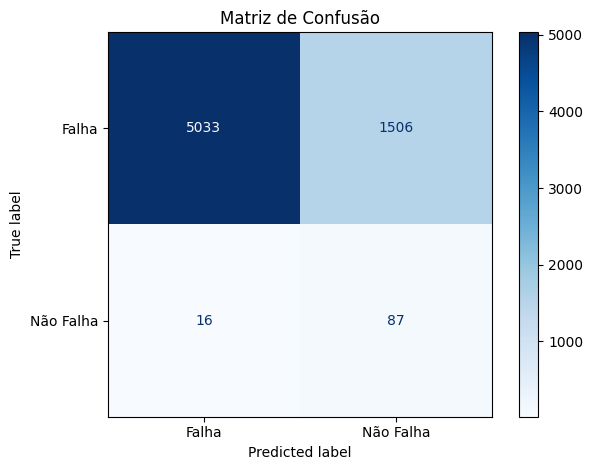

--------------------------------

LogisticRegression() Baseline
--------------------------------


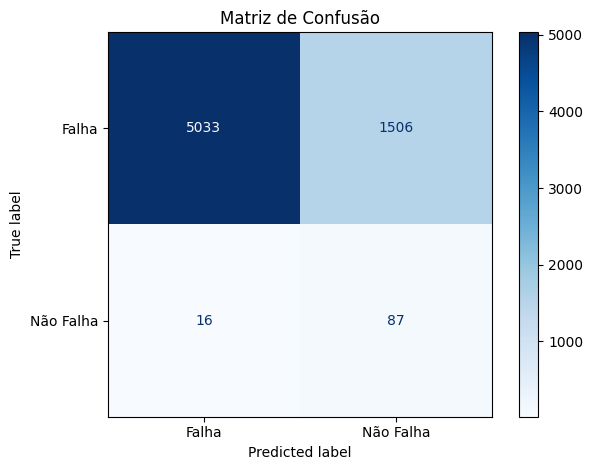

--------------------------------
RandomForestClassifier() Hyperparameters tuned
--------------------------------


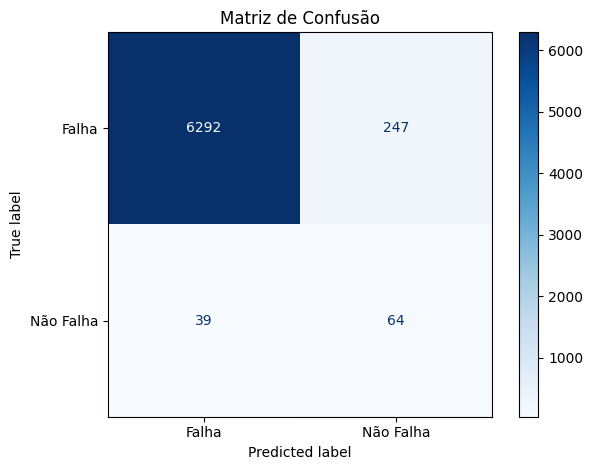

--------------------------------
XGBoost() Hyperparameters tuned
--------------------------------


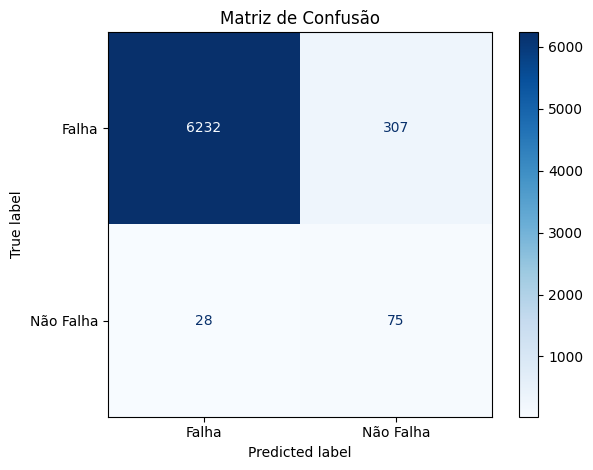

--------------------------------


In [29]:
# Matriz de Confusão
print("Matriz de Confusão")
print("--------------------------------")
print("LogisticRegression() Baseline")
print("--------------------------------")
cm = confusion_matrix(y_test, y_pred_lr_baseline)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Falha', 'Não Falha'])
disp.plot(cmap='Blues')
plt.title("Matriz de Confusão")
plt.tight_layout()
plt.show()
print("--------------------------------\n")

print("LogisticRegression() Baseline")
print("--------------------------------")
cm = confusion_matrix(y_test, y_pred_lr_tuned)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Falha', 'Não Falha'])
disp.plot(cmap='Blues')
plt.title("Matriz de Confusão")
plt.tight_layout()
plt.show()
print("--------------------------------")

print("RandomForestClassifier() Hyperparameters tuned")
print("--------------------------------")
cm = confusion_matrix(y_test, y_pred_rf_tuned)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Falha', 'Não Falha'])
disp.plot(cmap='Blues')
plt.title("Matriz de Confusão")
plt.tight_layout()
plt.show()
print("--------------------------------")


print("XGBoost() Hyperparameters tuned")
print("--------------------------------")
cm = confusion_matrix(y_test, y_pred_xgb_tuned)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Falha', 'Não Falha'])
disp.plot(cmap='Blues')
plt.title("Matriz de Confusão")
plt.tight_layout()
plt.show()
print("--------------------------------")

**Insights:**
- 

- **Baseline (Logistic Regression)**
    - Sensibilidade alta para falhas (recall=0.8447 → apenas 16 falhas reais não detectadas).
    - Precisão muito baixa (0.0546): de 1.593 alertas de falha gerados (1506 FP + 87 TP), apenas 87 eram falhas reais → ~94,5% falsos positivos.
    - 24% do conjunto foi sinalizado como falha — alto para operação.
    - O tuning não alterou o comportamento
    - Insight: Inviável na prática pelo volume de falsos alarmes.
    - O gargalo continua sendo a precisão do positivo
    - Oportunidade: Ajuste do limiar de decisão (thereshold)

## Explicabilidade do Modelo (XAi)
- Usado a biblioteca `explainerdashboard` como ferramenta de explicabilidade do modelo.

In [ ]:
from explainerdashboard import ClassifierExplainer, ExplainerDashboard

# Criar o explainer usando o pipeline final treinado (best_pipe) ao invés do objeto de busca (xgb_search)
explainer = ClassifierExplainer(best_pipe, X_test, y_test) #best_pipe

dashboard = ExplainerDashboard(explainer, 
                               title="Predictive Maintenance: Classifier Explainer XGBoost",
                               whatif=False,
                               shap_interaction=False,
                               decision_trees=False)

dashboard.run(host='127.0.0.1', 
             port=8050,  
             use_waitress=True) 

dashboard.save_html("../reports/classifier_explainer/XGBoost.html")

splitting pipeline...
Detected sklearn/imblearn Pipeline and succesfully extracted final output dataframe with column names and final model...
Detected XGBClassifier model: Changing class type to XGBClassifierExplainer...
Note: model_output=='probability'. For XGBClassifier shap values normally get calculated against X_background, but paramater X_background=None, so using X instead
Generating self.shap_explainer = shap.TreeExplainer(model, X, model_output='probability', feature_perturbation='interventional')...
Note: Shap interaction values will not be available. If shap values in probability space are not necessary you can pass model_output='logodds' to get shap values in logodds without the need for a background dataset and also working shap interaction values...
Building ExplainerDashboard..
Detected notebook environment, consider setting mode='external', mode='inline' or mode='jupyterlab' to keep the notebook interactive while the dashboard is running...
Generating layout...
Calcul

c:\Users\reyna\_python_projects\personal\portfolio-projects\predictive-maintenance-failure-classifier\.venv\Lib\site-packages\explainerdashboard\dashboards.py:649: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
100%|===================| 6634/6642 [01:01<00:00]        

Calculating prediction probabilities...
Calculating metrics...
Calculating confusion matrices...
Calculating classification_dfs...
Calculating roc auc curves...
Calculating pr auc curves...
Calculating liftcurve_dfs...
Calculating dependencies...
Calculating permutation importances (if slow, try setting n_jobs parameter)...
Calculating pred_percentiles...
Calculating predictions...
Reminder: you can store the explainer (including calculated dependencies) with explainer.dump('explainer.joblib') and reload with e.g. ClassifierExplainer.from_file('explainer.joblib')
Registering callbacks...
Starting ExplainerDashboard on http://192.168.3.133:8050
